# Time-Series Analysis on JetRail

## Problem Statement
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, we need to forecast the traffic on JetRail for the next 7 months. we are provided with traffic data of JetRail since inception in the test file.

### Hypothesis Generation
Hypothesis generation helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

a. There will be an increase in the traffic as the years pass by.     
    • Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.

b. The traffic will be high from May to October.    
    • Explanation - Tourist visits generally increases during this time perion.

c. Traffic on weekdays will be more as compared to weekends/holidays.   
    • Explanation - People will go to office on weekdays and hence the traffic will be more

d. Traffic during the peak hours will be high.    
    • Explanation - People will travel to work, college.

We will try to validate each of these hypothesis based on the datasets

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

#### Import the packages

In [1]:
import pandas as pd
import numpy as np     # For mathematical calculations
import matplotlib.pyplot as plt    # For plotting graphs
from datetime import datetime     # To access datetime
from pandas import Series     # To work on series
%matplotlib inline
import warnings         # To ignore warnings
warnings.filterwarnings("ignore")

#### Now, let's read the train and test data

In [2]:
train = pd.read_csv("Train_SU63ISt.csv")
test = pd.read_csv("Test_0qrQsBZ.csv")

#### Let's make a copy of train and test data so that even if we do changes in these dataset we do not lose the original dataset. 

In [3]:
train_original=train.copy()
test_original=test.copy()

### Dataset Structure and content

In [4]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

#### We have ID, Datetime and corresponding count of passengers in the train file. For test file, we have ID and Datetime only so we have to predict the Count for test file.

##### Let's understand each feature first:
1. ID is the unique number given to each observation point.
2. Datetime is the time of each observation.
3. Count is the passenger count corresponding to each Datetime.

##### Let's look at the datatype of each feature.

In [5]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [6]:
# shape of the dataset
train.shape, test.shape

((18288, 3), (5112, 2))

## Exploration and Preprocessing

### Feature Extraction
##### We will extract the time and date from the Datetime. We have seen earlier that the datatype of Datetime is object. So first of all we have to change the datatype to datetime format otherwise we cannot extract features from it.

In [7]:
train['Datetime']= pd.to_datetime(train.Datetime, format= '%d-%m-%Y %H:%M')
test['Datetime']= pd.to_datetime(test.Datetime, format= '%d-%m-%Y %H:%M')
train_original['Datetime']= pd.to_datetime(train.Datetime, format= '%d=%m-%Y %H:%M')
test_original['Datetime']= pd.to_datetime(test.Datetime, format= '%d=%m-%Y %H:%M')

In [8]:
# We made some hypothesis for the effect of hour, day, month and year omn the passenger count. 
# So, let's extract the year, month, day and hour from the Datetime to validate our hypothesis.
for i in (train, test, train_original, test_original):
    i['year']=i.Datetime.dt.year
    i['month']=i.Datetime.dt.month
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

In [9]:
# We made a hypothesis for the traffic pattern on weekday and weekend as well. 
# So, let's make a weekend variable to visualize the impact of weekend on traffic.
## We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.
## Values of 5 and 6 represents that the days are weekend.
train['day of week']=train['Datetime'].dt.dayofweek
temp=train['Datetime']
### Let's assign 1 if the day of the week is a weekend and 0 if the day of the week is not a weekend.
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = train['Datetime'].apply(applyer)
train['weekend']=temp2

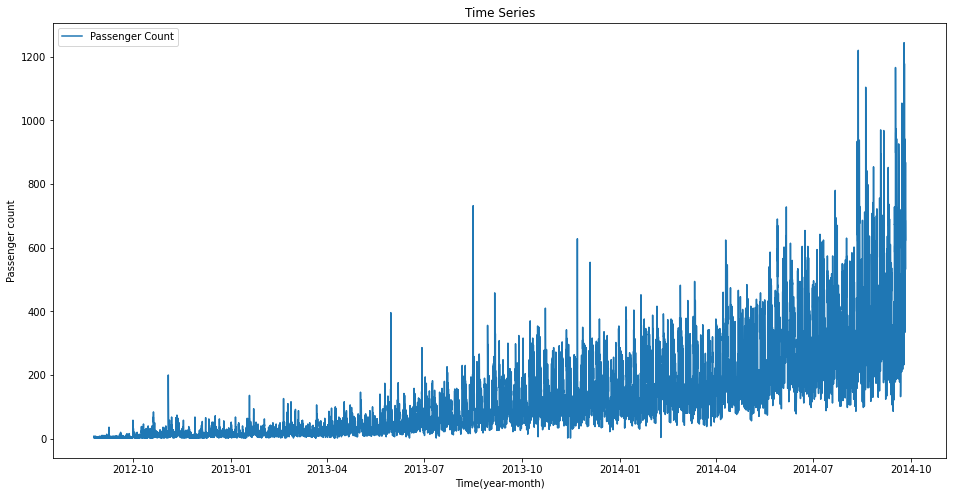

In [10]:
# Let's look at the Time Series
train.index = train['Datetime']  # indexing the Datetime to get the time-period on the x-axis.
df=train.drop('ID', 1)    # drop ID variable to get only the Datetime on x-axis.
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

Here we can infer that there's an increasing trend in the series.i.e., the number of count is increasing with respect to time. We can also see that at certain points there's a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.
We will work on the train file for all the analysis and will use the test file for forecasting.

#### Lets recall the hypothesis that we made earlier:

1. Traffic will increase as the years pass by
2. Traffic will be high from May to October
3. Traffic on weekdays will be more
4. Traffic during the peak hours will be high

After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the datatset.


## Exploratory Analysis

<AxesSubplot:xlabel='year'>

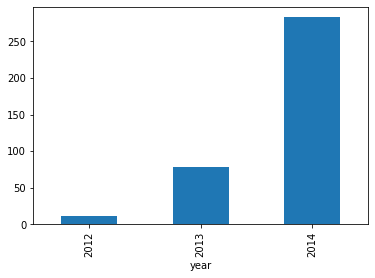

In [11]:
# Let's try to verify our hypothesis using actual data 
# Our first hypothesis was traffic will increase as the years pass by. So, let's look at yearly passenger count
train.groupby('year')['Count'].mean().plot.bar()

We see an exponential growth in the traffic with respect to year which validates our hypothesis

<AxesSubplot:xlabel='month'>

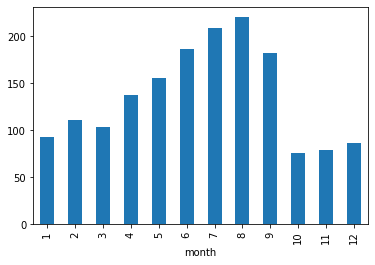

In [12]:
# Our second hypothesis was about increase in traffic from May to October. So, let's see the relation between count and month.
train.groupby('month')['Count'].mean().plot.bar()

Here, we see a decrease in the mean of passenger count in last three months. This does not look right. 

<AxesSubplot:title={'center':'Passenger Count(Monthwise)'}, xlabel='year,month'>

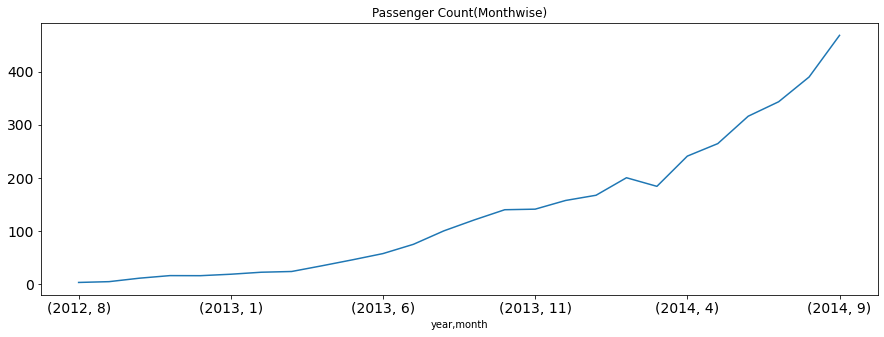

In [13]:
# Let's look at monthly mean of each year separately
temp = train.groupby(['year','month'])['Count'].mean()
temp.plot(figsize = (15,5),title = "Passenger Count(Monthwise)",fontsize=14)

- We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.

- Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.

- In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

<AxesSubplot:xlabel='day'>

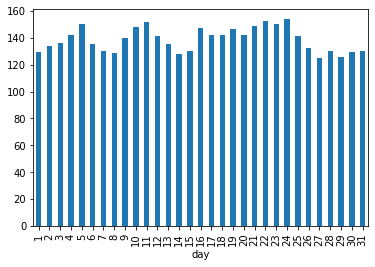

In [14]:
# Let’s look at the daily mean of passenger count.
train.groupby('day')['Count'].mean().plot.bar()

We are not getting much insights from day wise count of the passengers.

<AxesSubplot:xlabel='Hour'>

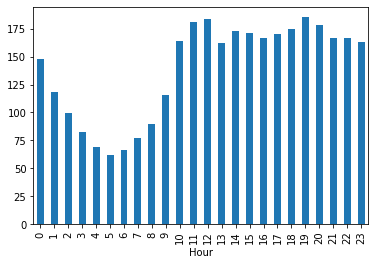

In [15]:
# We also made a hypothesis that the traffic will be more during peak hours. So let's see the mean of hourly passenger count.
train.groupby('Hour')['Count'].mean().plot.bar()

- It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
- After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

<AxesSubplot:xlabel='weekend'>

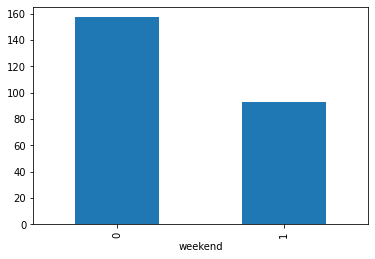

In [16]:
# Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.
train.groupby('weekend')['Count'].mean().plot.bar()

- It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

<AxesSubplot:xlabel='day of week'>

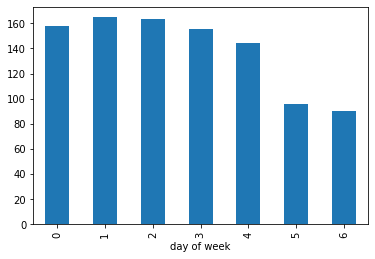

In [17]:
# Now, we will try to look at the day wise passenger count.
# Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.
train.groupby('day of week')['Count'].mean().plot.bar()

- From the above bar plot, we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week

In [18]:
# Before looking at the basic modeling techniques, we will drop the ID variable as it has nothing to do with the passenger count.
train=train.drop('ID',1)

##### As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [19]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

In [20]:
# Hourly time series 
hourly = train.resample('H').mean()

# Converting to daily mean 
daily = train.resample('D').mean() 

# Converting to weekly mean 
weekly = train.resample('W').mean() 

# Converting to monthly mean 
monthly = train.resample('M').mean()

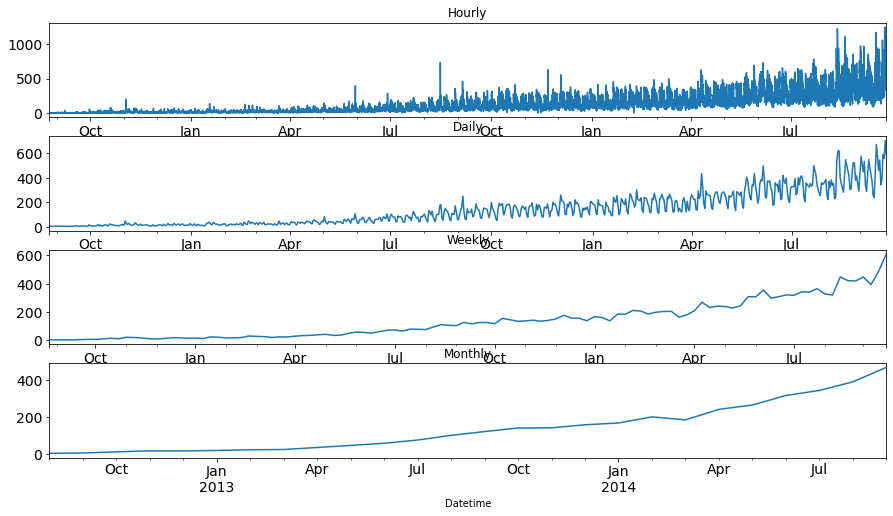

In [21]:
# Let’s look at the hourly, daily, weekly and monthly time series.

fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

- We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

- But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [22]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp

# Converting to daily mean 
test = test.resample('D').mean()

In [23]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

# Converting to daily mean 
train = train.resample('D').mean()

## "Forecasting using Multiple Modeling Techniques and Evaluation"
As we have validated all our hypothesis, let's go ahead and build models for Time Series Forecasting. But before we do that, we will need a dataset(validation) to check the performance and generalisation ability of our model. Below are some of the properties of the dataset required for the purpose.
- The dataset should have the true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.
- The model should not be trained on the validation dataset. Hence, we cannot train the model on the train dataset and vlidate on it as well.
So, for the above two reasons we genrally divide the train dataset into two parts. One part is used to train the model and the other part is used as the validation dataset. Now there are multiple ways to divide the train dataset such as Random Division etc. You can look for all of the differnt validation methods here: https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/    
Here, we will use a time based split explained below.

### Splitting the data into training and validation part

Now, we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.
- NOTE - It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric(rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most n them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.  
The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.


In [24]:
Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']

 - We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

 - Lets understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

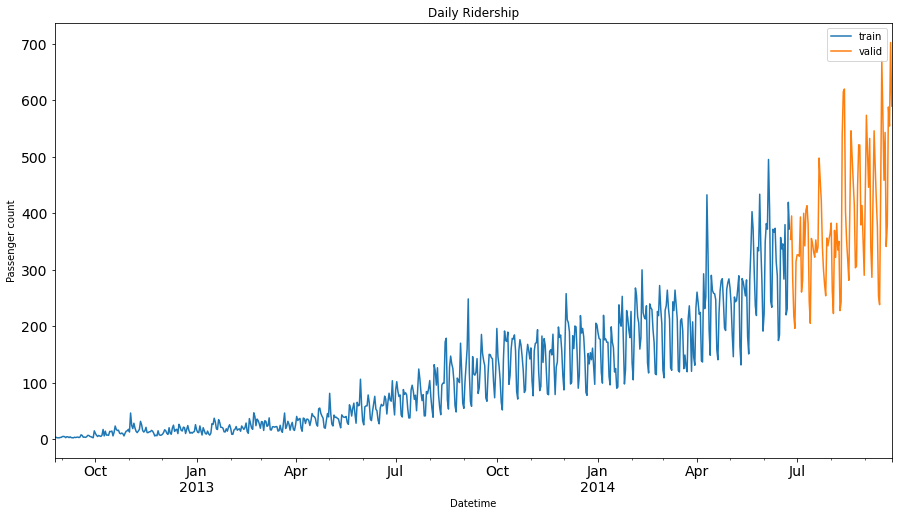

In [25]:
# how the train and validaiton part has been divided

Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

 - Here the blue part represents the train data and the orange part represents the validation data.

 - We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.

## Modeling Techniques

We will look at the various models now to forecast the time series. Methods which we will be discussing for the forecasting are:     
i) Naive Approach          
ii) Moving Average        
iii) Simple Exponential Smoothing      
iv) Holt's Linear Trend Model   

### i) Naive Approach   
In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. Lets understand it with an example and an image:

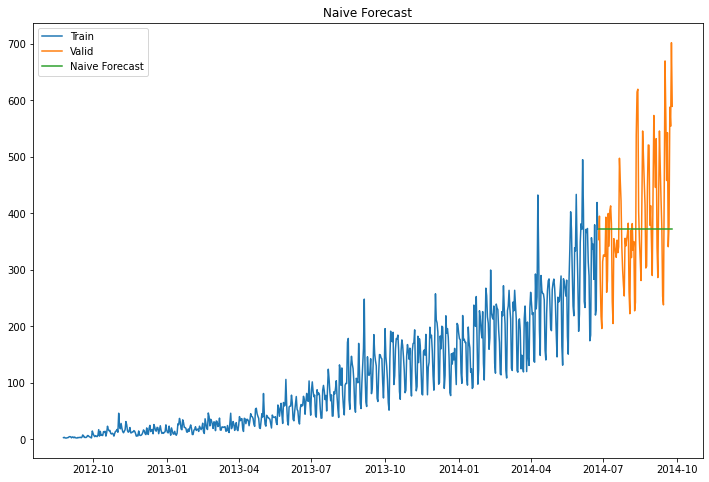

In [26]:
# Predictions using navie approach

dd= np.asarray(Train.Count) 
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

 - We can calculate how accurate our predictions are using rmse(Root Mean Square Error).   
 - rmse is the standard deviation of the residuals.    
 - Residuals are a measure of how far from the regression line data points are.    
 - The formula for rmse is:  rmse=sqrt∑i=1N1N(p−a)2    

In [27]:
# We will now calculate RMSE to check the accuracy of our model on validation data set.

from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


 - We can infer that this method is not suitable for datasets with high variability. We can reduce the rmse value by adopting different techniques.

### ii) Moving Average
In this technique we will take the average of the passenger counts for last few time periods only.   
Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values.

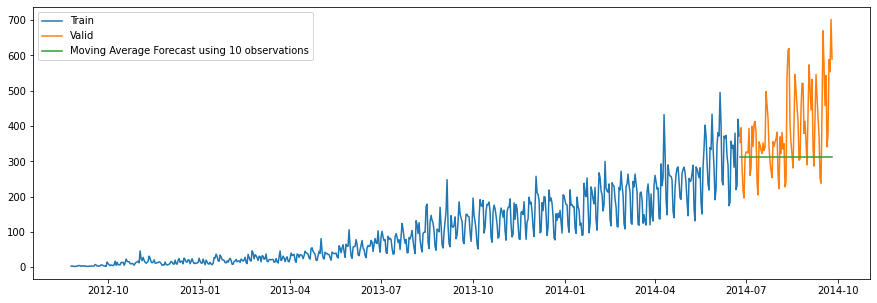

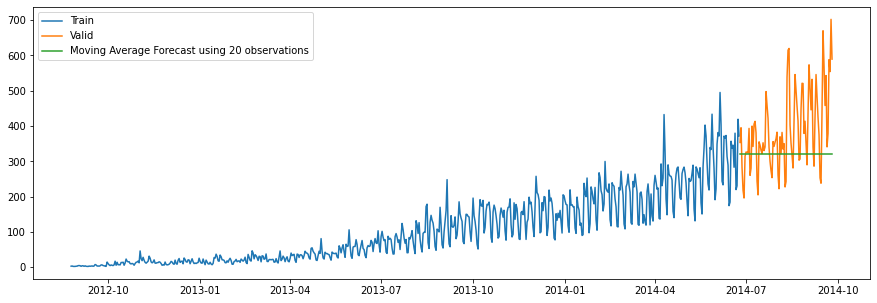

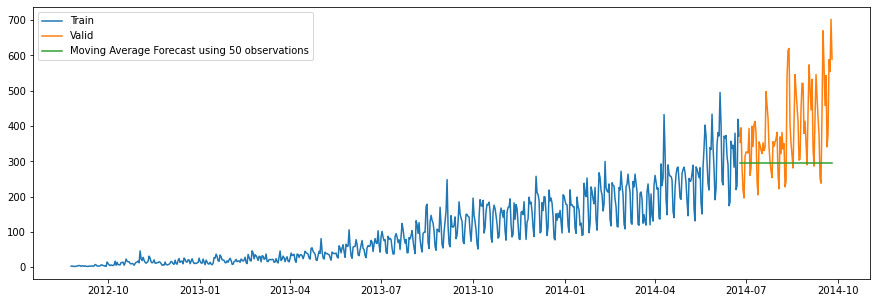

In [28]:
# Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

 - We took the average of last 10, 20 and 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part. We can see that the predictions are getting weaker as we increase the number of observations.

In [29]:
# RMS
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

144.19175679986793


### iii) Simple Exponential Smoothing
In this technique, we assign larger weights to more recent observations than to observations from the distant past.
The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

- NOTE - If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.

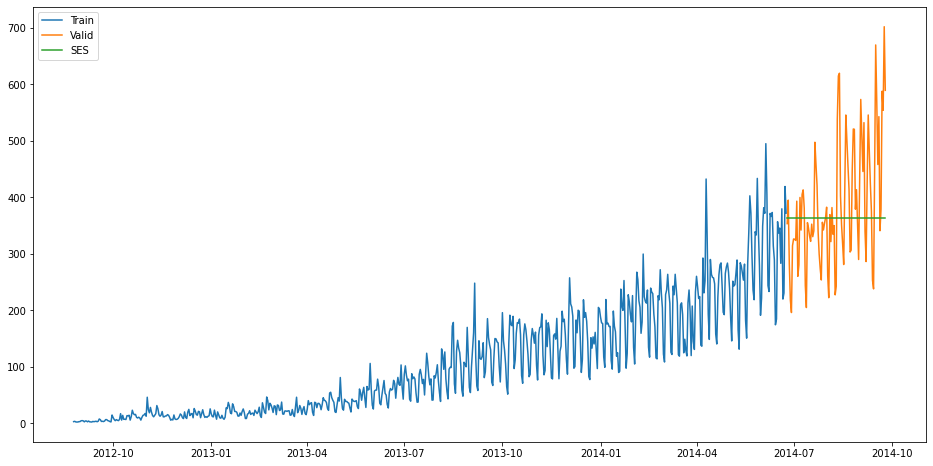

In [30]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [31]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

113.43708111884514


- We can infer that the fit of the model has improved as the rmse value has reduced.

### iv) Holt’s Linear Trend Model      
It is an extension of simple exponential smoothing to allow forecasting of data with a trend.   
This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend. 
First of all let us visualize the trend, seasonality and error in the series.   

We can decompose the time series in four parts.    

 - Observed, which is the original time series.
 - Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
 - Seasonal, which tells us about the seasonality in the time series.
 - Residual, which is obtained by removing any trend or seasonality in the time series.

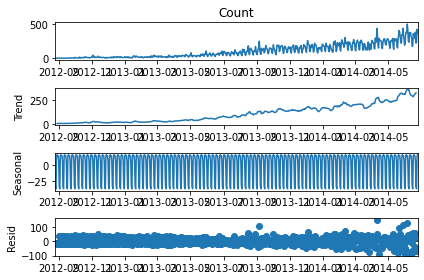

In [32]:
# Lets visualize all these parts.

import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

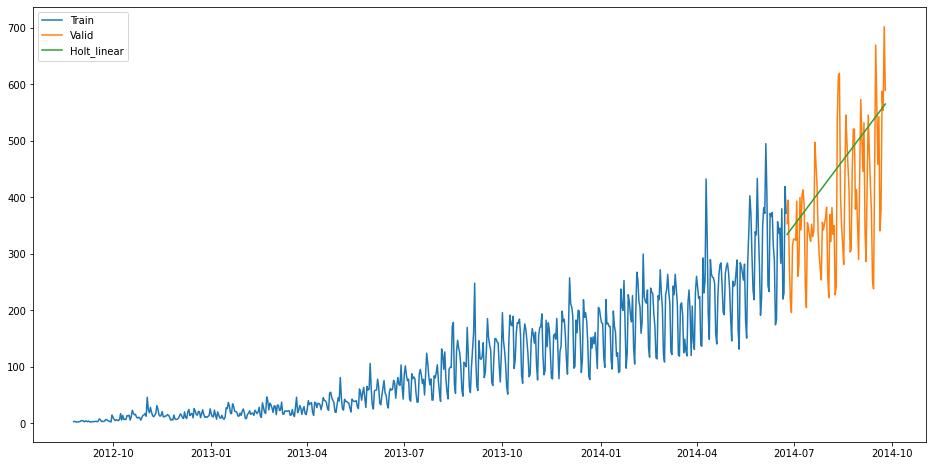

In [33]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [34]:
# Let’s calculate the rmse of the model.
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


- It can be inferred that the rmse value has decreased.

### Holt winter’s model on daily time series
- Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

- The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

- One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

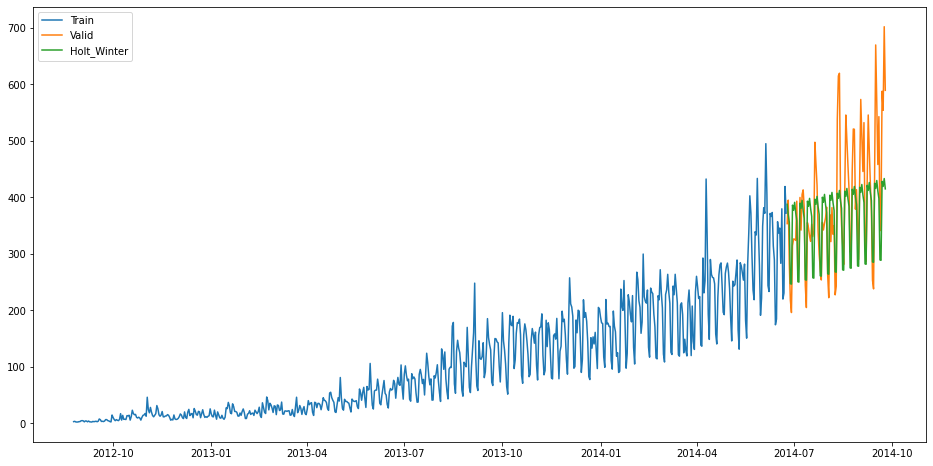

In [35]:
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [36]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)

82.13941073668202


- Holt winters model produced rmse of 82.3793

### Its Time For - Much Anticipated ARIMA

### Introduction to ARIMA model
- ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).

- Here p is the order of the autoregressive model(number of time lags)

- d is the degree of differencing(number of times the data have had past values subtracted)

- q is the order of moving average model. We will discuss more about these parameters in next section.

##### What is a stationary time series?

There are three basic criterion for a series to be classified as stationary series :

- The mean of the time series should not be a function of time. It should be constant.
- The variance of the time series should not be a function of time.-
- The covariance of the ith term and the (i+m)th term should not be a function of time.

### Parameter tuning for ARIMA model
#### Stationarity Check
- We use Dickey Fuller test to check the stationarity of the series.
- The intuition behind this test is that it determines how strongly a time series is defined by a trend.
- The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [37]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(train_original):
        #Determing rolling statistics
    rolmean = train_original.rolling(24).mean() # 24 hours on each day
    rolstd = train_original.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(train_original, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(train_original, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

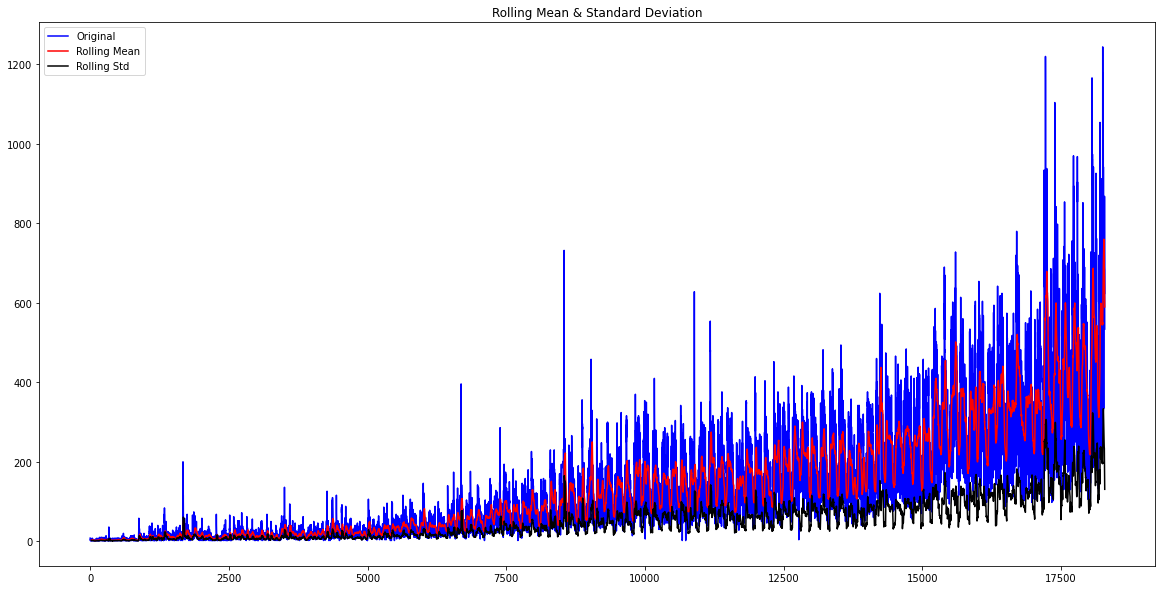

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [38]:
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

test_stationarity(train_original['Count'])

**The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.**

### Removing Trend
- A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.
- We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.
- We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

In [39]:
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])

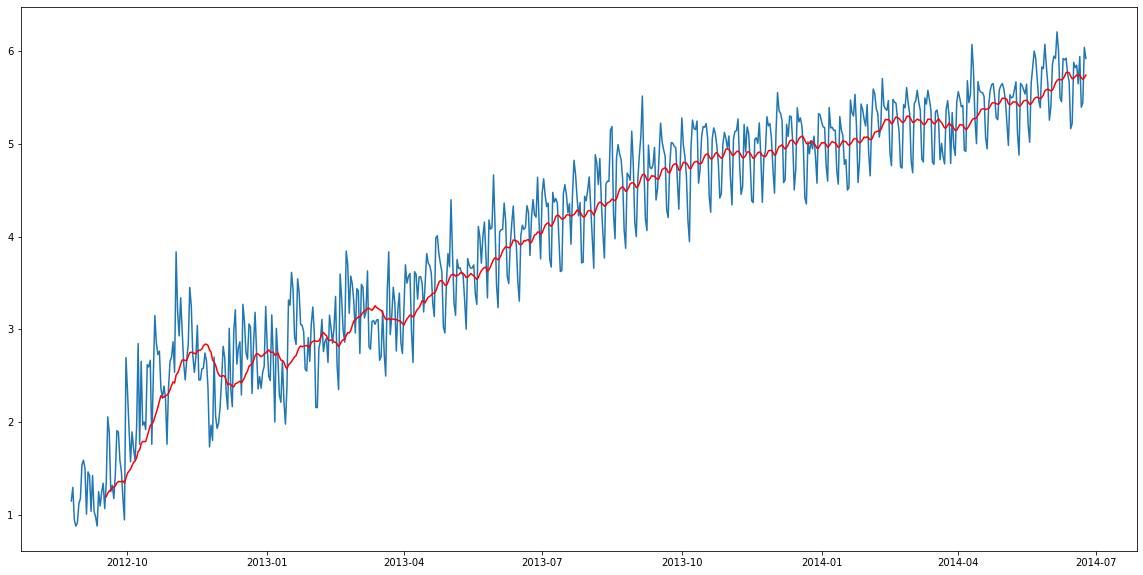

In [40]:
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

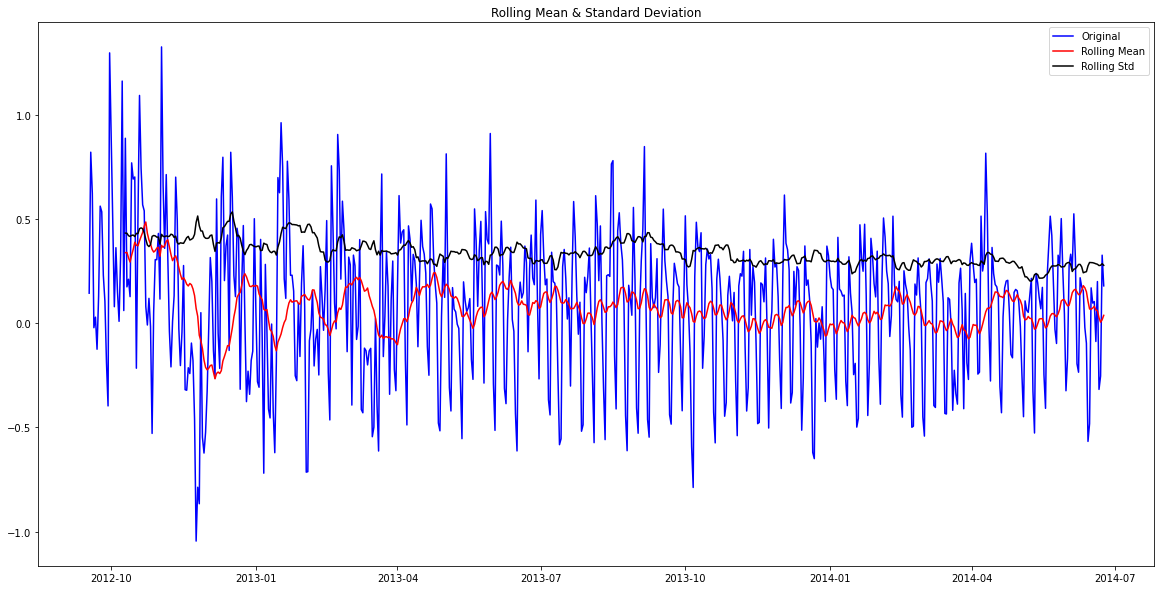

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [41]:
train_log_moving_avg_diff = Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

- We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.
- Differencing can help to make the series stable and eliminate the trend.

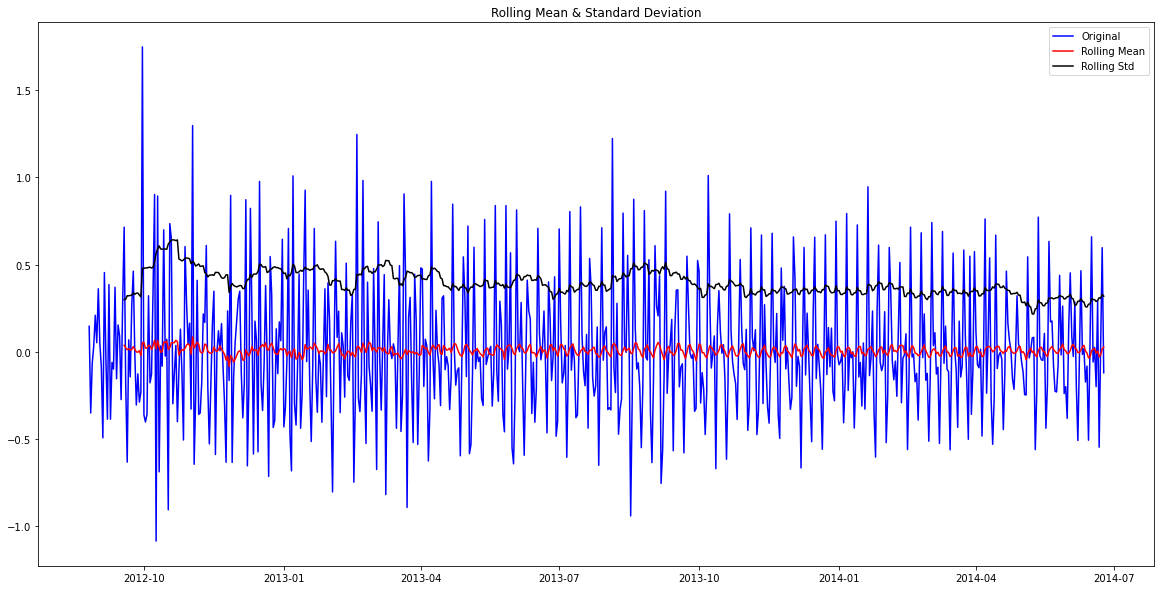

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [42]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

### Removing Seasonality
- By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
- Seasonality is always of a fixed and known period.
- We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

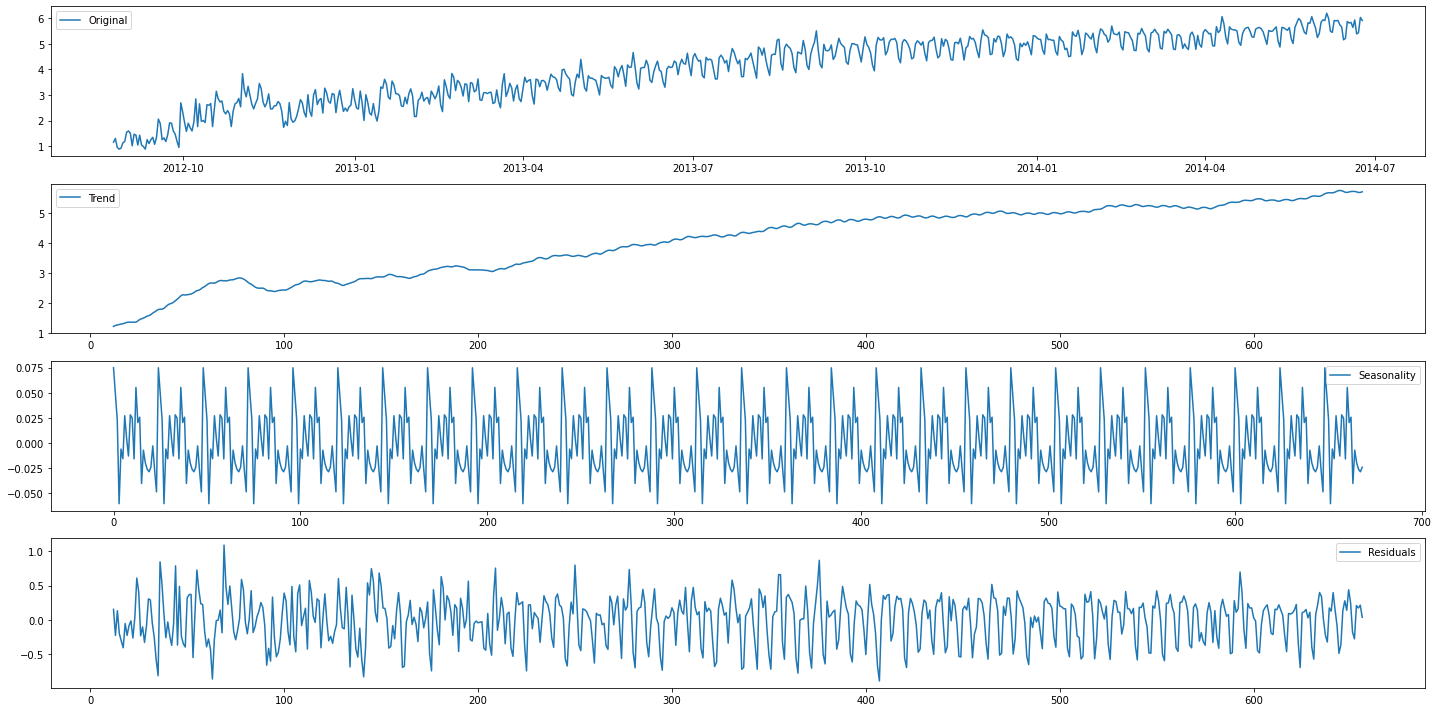

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

- We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.

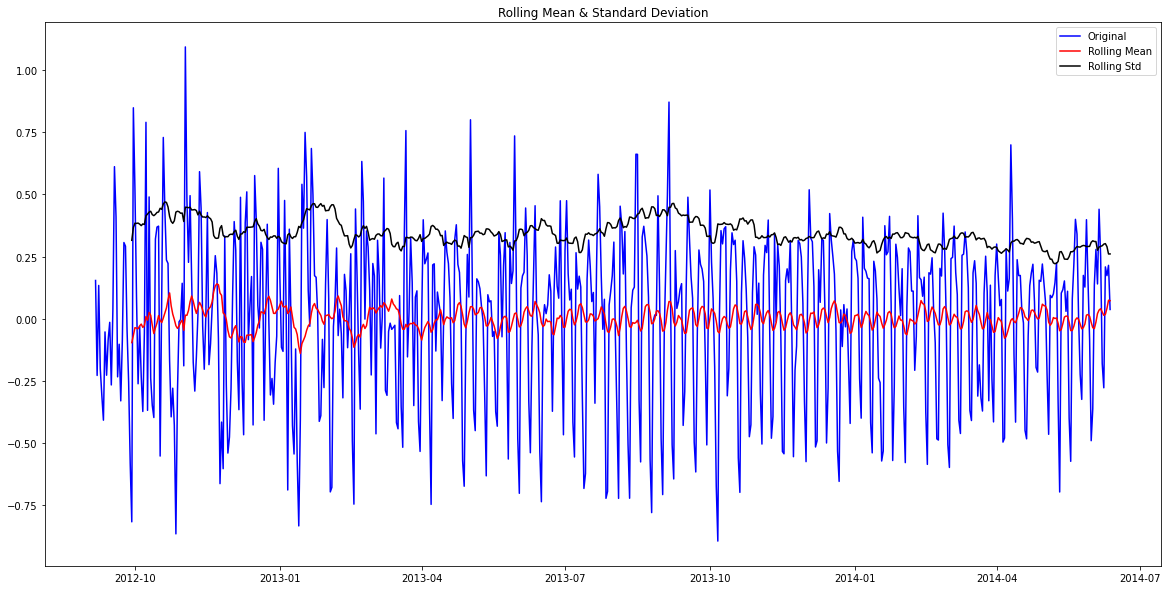

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [44]:
# Let’s check stationarity of residuals.

train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

- It can be interpreted from the results that the residuals are stationary.

- Now we will forecast the time series using different models.

### Forecasting the time series using ARIMA
- First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters.

- To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

- ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.

- PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [45]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

### ACF and PACF plot

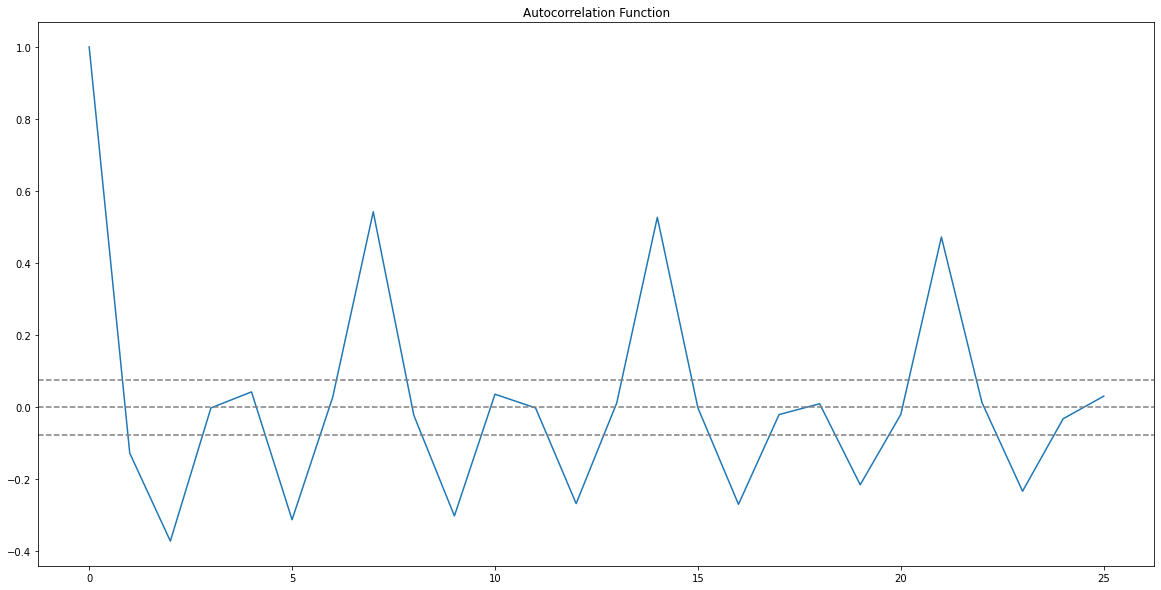

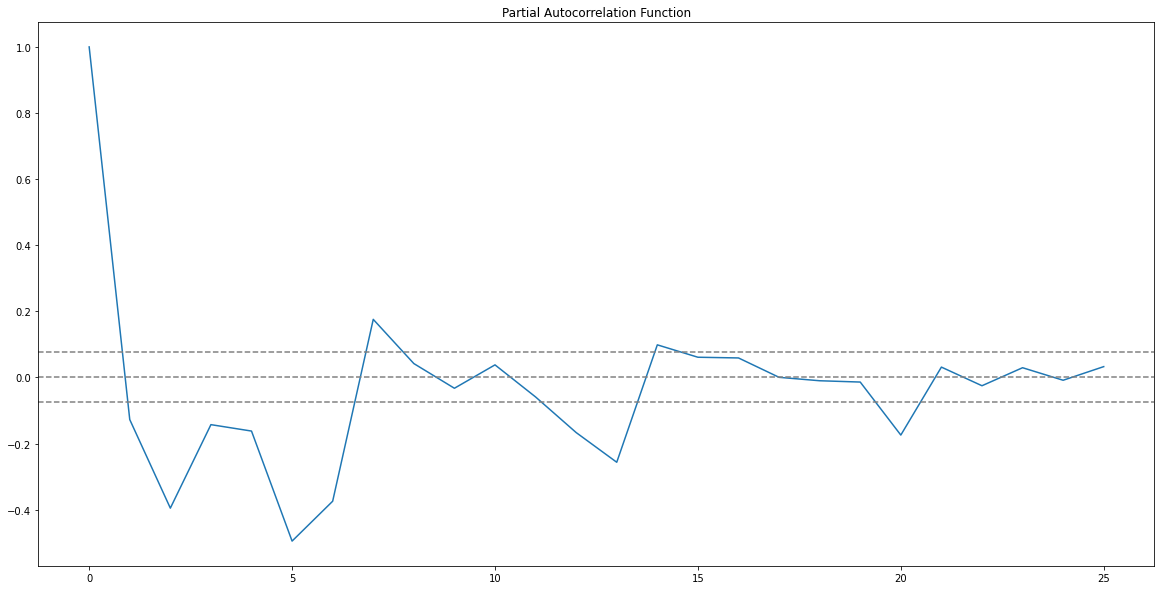

In [46]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

- p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.

- q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

- Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

### AR Model

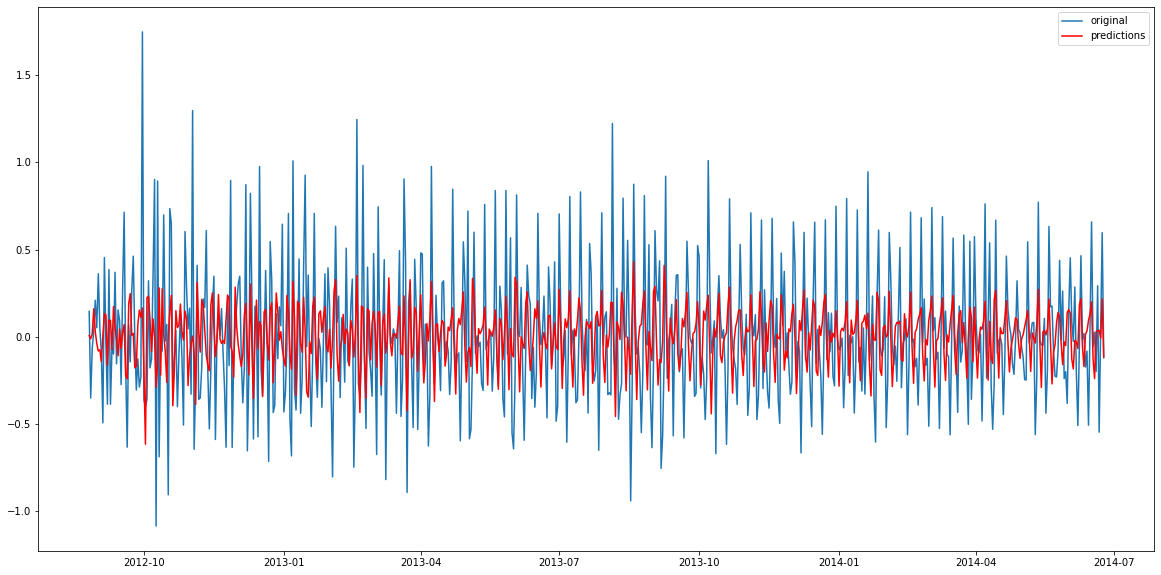

In [47]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

- Lets plot the validation curve for AR model.

- We have to change the scale of the model to the original scale.

- First step would be to store the predicted results as a separate series and observe it.

In [48]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)

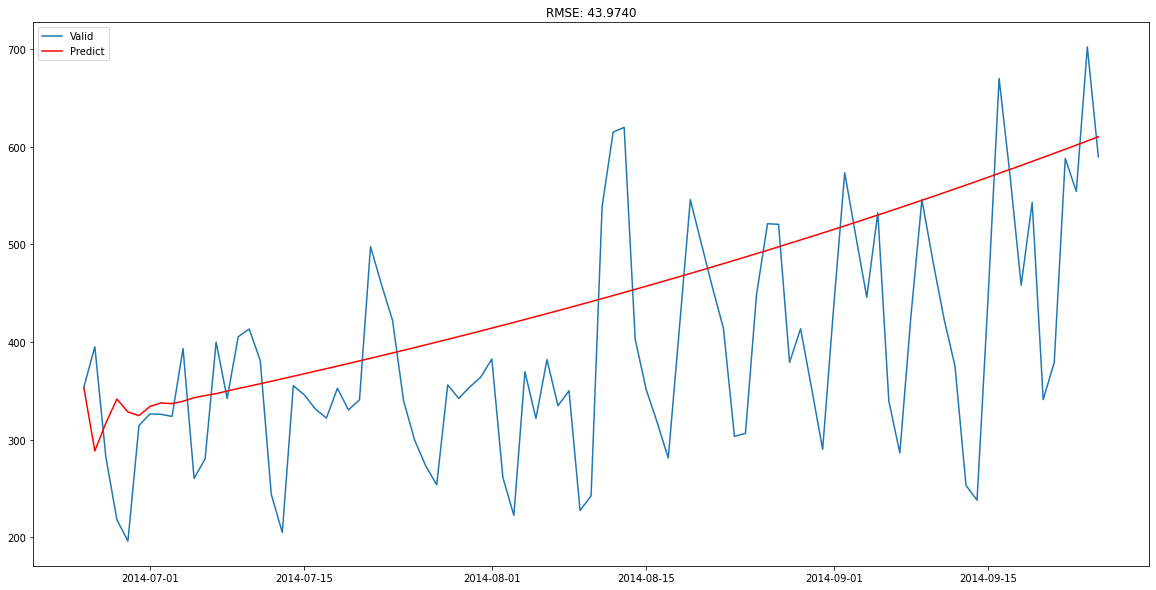

In [49]:
plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()

- Here the red line shows the prediction for the validation set. Let’s build the MA model now.

### MA Model

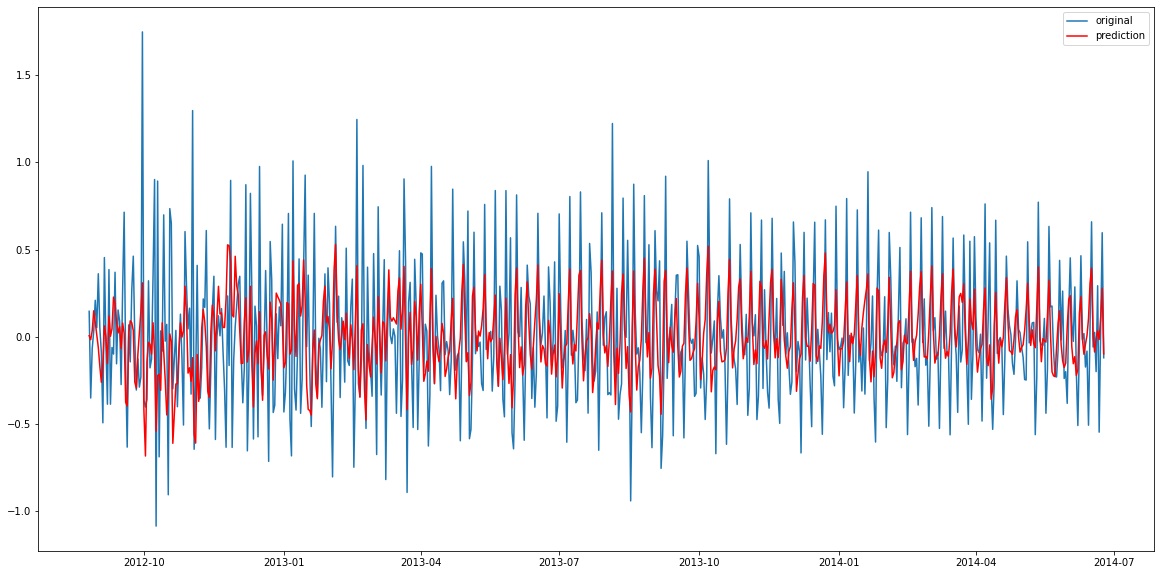

In [50]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

In [51]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)

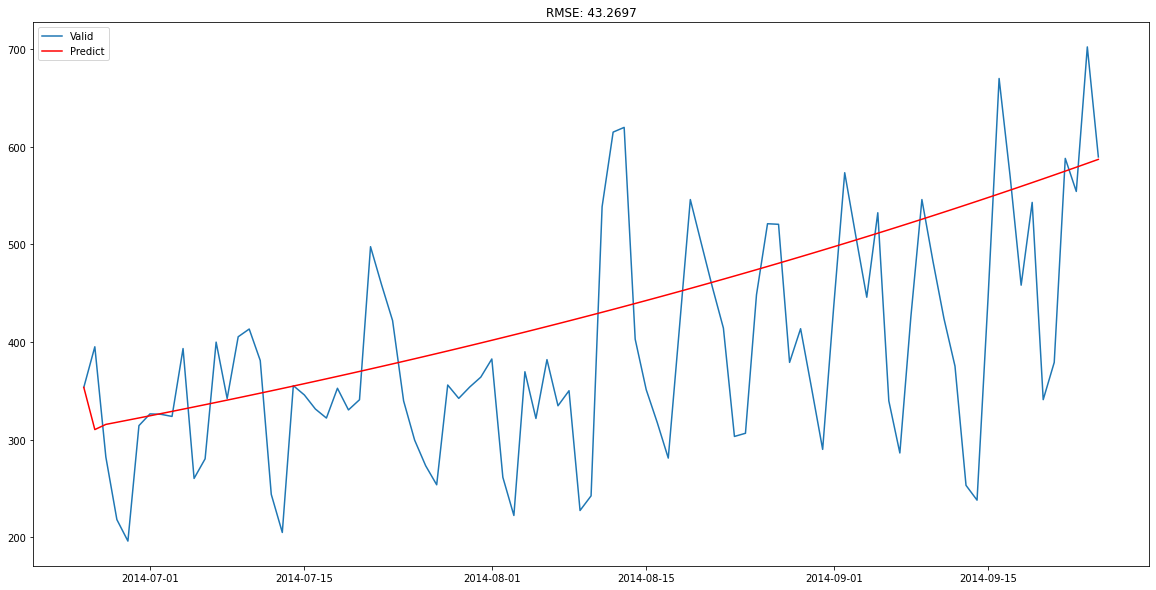

In [52]:
plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()

### Combine Model

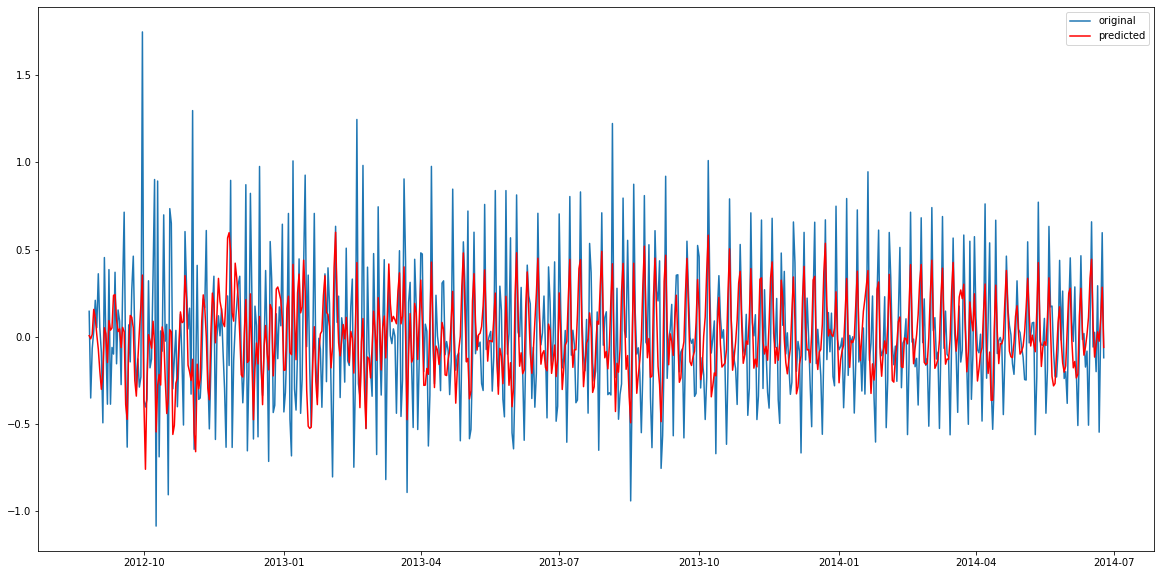

In [53]:
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [54]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [55]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

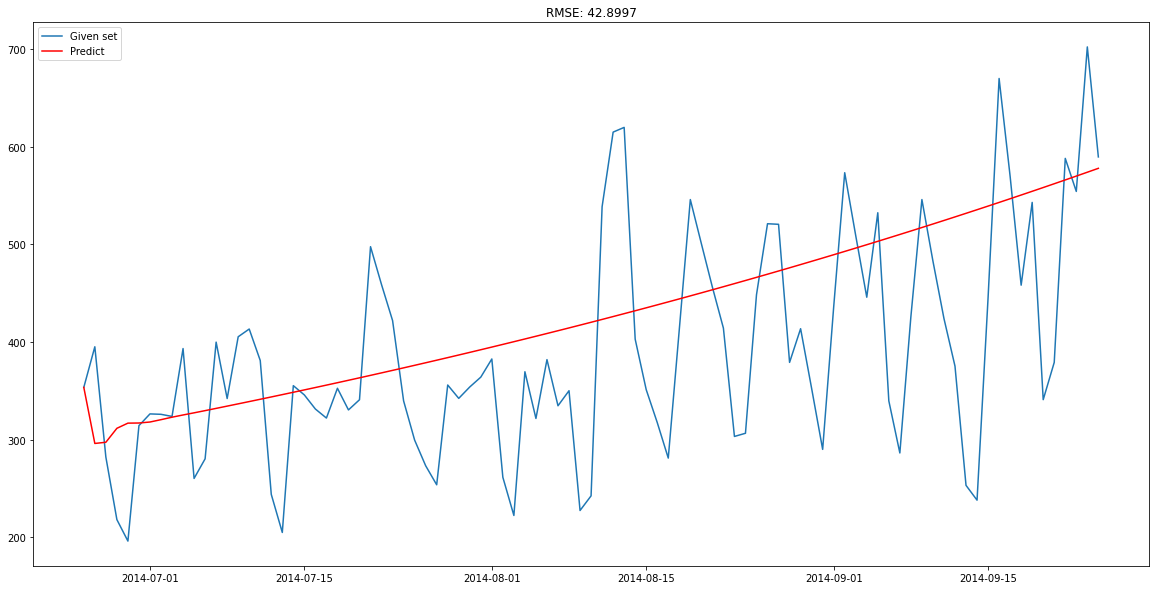

In [56]:
# Predict the Values for validation set
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

### SARIMAX model on daily time series

c:\users\admin\appdata\local\programs\python\python39-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


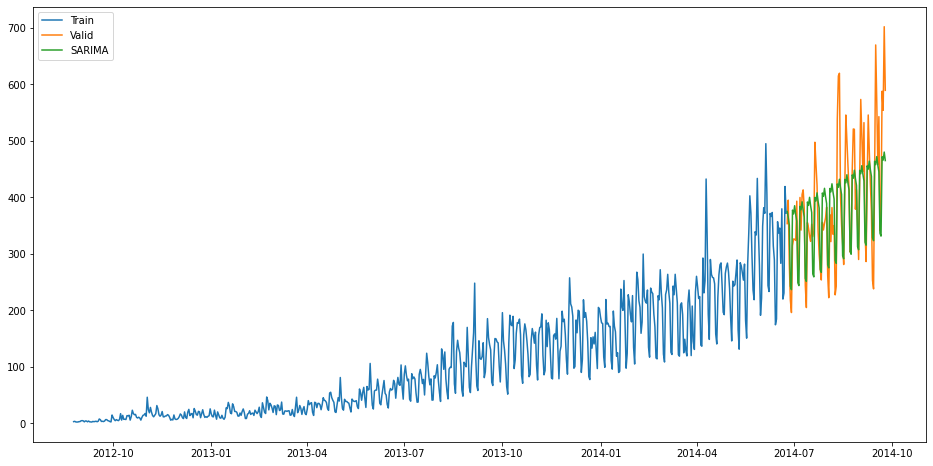

In [57]:
import statsmodels.api as sm

y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

- Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

- Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

- In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

In [58]:
## Let’s check the rmse value for the validation part.

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print(rms)

69.9604725367554
